# Wind, solar and demand climatology

In [1]:
import xarray as xr
import numpy as np

import string
letters = list(string.ascii_lowercase)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches

In [2]:
%cd /g/data/w42/dr6273/work/seasonal_energy/

import functions as fn

/g/data/w42/dr6273/work/seasonal_energy


In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
REGIONS = ['NSW', 'QLD', 'VIC', 'SA', 'TAS']

## Load data

Demand

In [5]:
demand_current = fn.load_monthly("demand_state_training2010-16_extrapolate1940-2023")["demand"]

In [6]:
demand_SC30 = fn.load_monthly("demand_state_step_change_2029-30_training2010-16_extrapolate1940-2023")["demand"]

In [7]:
demand_SC40 = fn.load_monthly("demand_state_step_change_2039-40_training2010-16_extrapolate1940-2023")["demand"]

In [8]:
demand_SC50 = fn.load_monthly("demand_state_step_change_2049-50_training2010-16_extrapolate1940-2023")["demand"]

In [9]:
aemo_demand = fn.load_monthly("aemo_demand_2010-19_detrended")["demand_stl"]

Current capacities

In [10]:
wind_current = fn.load_monthly("wind_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [11]:
solar_current = fn.load_monthly("solar_power_REZ_current_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [12]:
shortfall_current = fn.load_monthly("shortfall_REZ_current_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

Future capacities

In [13]:
wind_SC30 = fn.load_monthly("wind_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [14]:
solar_SC30 = fn.load_monthly("solar_power_REZ_step_change_2029-30_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [15]:
shortfall_SC30 = fn.load_monthly("shortfall_REZ_step_change_2029-30_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

In [16]:
wind_SC40 = fn.load_monthly("wind_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [17]:
solar_SC40 = fn.load_monthly("solar_power_REZ_step_change_2039-40_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [18]:
shortfall_SC40 = fn.load_monthly("shortfall_REZ_step_change_2039-40_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

In [19]:
wind_SC50 = fn.load_monthly("wind_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [20]:
solar_SC50 = fn.load_monthly("solar_power_REZ_step_change_2049-50_state_van_der_Wiel_era5_monthly_1940-2023")["power"]

In [21]:
shortfall_SC50 = fn.load_monthly("shortfall_REZ_step_change_2049-50_state_van_der_Wiel_training2010-16_extrapolate1940-2023")["shortfall"]

## Monthly climatology

In [22]:
def stack_yearly(ds):
    """
    Reshape array to year and monthly coords
    """
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")  

In [23]:
def get_violin_data(ds):
    """
    Return list of lists of monthly data from ds
    """
    # ds = stack_yearly(ds)
    L = []
    for m in range(1, 13):
        # L.append(list(ds.sel(month=m).values))
        L.append(list(fn.sel_month(ds, month=m).values))
    return L

In [24]:
def plot_violin(ax, ds_list, labels, colors=["tab:gray", "tab:orange", "tab:green"], x_offsets = [-0.2, 0, 0.2], v_width=0.5):
    """
    Violin plot for each list in data_list
    
    ax: axis to plot onto
    data_list: list, containing datasets to plot
    labels: list, labels of data
    colors: list, colors to plot. For 2 data sets, will exclude the middle one.
    x_offsets: list, spacing between data sets on x-axis. For 2 data sets, will exclude the middle one.
    v_width: float, widths of violins
    """
    legend_items = []
    def _add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        legend_items.append((mpatches.Patch(color=color), label))
        
    # If only 2 datasets to plot, remove the middle color and x_offset
    if len(ds_list) == 2:
        colors = [colors[0], colors[-1]]
        x_offsets = [x_offsets[0], x_offsets[-1]]
    # If 4 datasets to plot, append new colour and change x_offsets
    if len(ds_list) == 4:
        colors = colors + ["tab:blue"]
        # x_offsets = [-0.2, -0.1, 0.1, 0.2]
        x_offsets = [-0.3, -0.1, 0.1, 0.3]
        
    # Get data for plotting
    data_list = [get_violin_data(d) for d in ds_list]
    
    # Plot
    for data, label, color, offset in zip(
        data_list, labels, colors, x_offsets
    ):
        vp = ax.violinplot(
            data,
            positions=np.arange(1 + offset, 12.01 + offset, 1),
            widths=v_width,
            # quantiles=[[0.025, 0.5, 0.975] for _ in range(12)],
            quantiles=[[0.05, 0.5, 0.95] for _ in range(12)],
            showextrema=False,
            # showmeans=False
        )
        # Set violin color
        for pc in vp['bodies']:
            pc.set_facecolor(color)
        # vp["cbars"].set_edgecolor(color)
        vp["cquantiles"].set_edgecolor(color)
        # vp["cmins"].set_edgecolor(color)
        # vp["cmaxes"].set_edgecolor(color)
        # vp["cmeans"].set_edgecolor(color)
        # Add legend label manually
        _add_label(vp, label) 
        
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])
    ax.set_xlim(0.5, 12.5)
    for x in np.arange(1.5, 12, 1):
        ax.axvline(x, c="lightgray")
    # ax.legend(*zip(*legend_items), loc=2)

In [25]:
def panel_violin(
    wind_ds, solar_ds, demand_ds, shortfall_ds, demand_obs_ds, regions,
    colors=["tab:gray", "tab:orange", "tab:green"],
    plot_demand=False, plot_demand_obs=False, period=None,
    column_titles=["Generation", "Demand and residual load"],
    yaxis_ticks=None,
    savefig=False, filename=None):
    """
    Plot generation and demand climatologies for all regions
    
    wind_ds, solar_ds, demand_ds, shortfall_ds, demand_obs_ds: datasets to plot
    regions: list, of regions to select
    colors: list, of colours
    plot_demand, plot_demand_obs: bool, whether or not to plot demand predictions/observations
    period: slice, desired time period. Otherwise ignore.
    column_titles: list of str, len 2, column headers
    yaxis_ticks: list of length 12, with each element an array of y-axis ticks
    savefig: bool, whether to save figure
    filename: str, name of file for saved figure
    """
    if isinstance(period, slice):
        winds_ds = wind_ds.sel(time=period)
        solar_ds = solar_ds.sel(time=period)
        demand_ds = demand_ds.sel(time=period)
        shortfall_ds = shortfall_ds.sel(time=period)
        demand_obs_ds = demand_obs_ds.sel(time=period)
        
    winds_ds = wind_ds.sel(region=regions)
    solar_ds = solar_ds.sel(region=regions)
    demand_ds = demand_ds.sel(region=regions)
    shortfall_ds = shortfall_ds.sel(region=regions)
    demand_obs_ds = demand_obs_ds.sel(region=regions)
    
    demand_obs_clim = demand_obs_ds.groupby("time.month").mean()
    
    # Plot
    fig, ax = plt.subplots(6, 2, figsize=(7, 8))

    for i,r in enumerate(regions):
        plot_violin(
            ax[i+0,0],
            [wind_ds.sel(region=r), solar_ds.sel(region=r), wind_ds.sel(region=r) + solar_ds.sel(region=r)],
            ["Wind", "Solar", "Both"],
            colors=colors
        )

        if plot_demand:
            plot_violin(
                ax[i+0,1],
                [demand_ds.sel(region=r), shortfall_ds.sel(region=r)],
                ["Demand", "Residual load"],
                colors=["tab:purple", "k", "tab:red"]
            )
            ylim = ax[i+0, 1].get_ylim()
            if ylim[0] < 0:
                ax[i+0, 1].axhline(0, c="k")
            
        if plot_demand_obs:
            ax[i+0,1].plot(
                np.arange(0.8, 11.9, 1),
                demand_obs_clim.sel(region=r).values,
                c="k"
            )
        ax[i+0,1].set_xlabel("")
        ax[i+0,1].set_ylabel("")
        ax[i+0,1].set_title("")

        ax[i+0,0].set_ylabel(r + "\n" + r"[TWh month$^{-1}$]")

    ax[0,0].set_title(column_titles[0])
    ax[0,1].set_title(column_titles[1])

    ax[-1,0].set_xlabel("Month")
    ax[-1,1].set_xlabel("Month")

    plt.tight_layout()

    # Manual legend   
    col1 = Line2D([0], [0], marker='', linestyle="-", color="tab:green")
    col2 = Line2D([0], [0], marker='', linestyle="-", color="tab:orange")
    col3 = Line2D([0], [0], marker='', linestyle="-", color="tab:blue")
    col4 = Line2D([0], [0], marker='', linestyle="-", color="tab:purple")
    col5 = Line2D([0], [0], marker='', linestyle="-", color="tab:red")
    col6 = Line2D([0], [0], marker='', linestyle="-", color="k")
    
    cols = [col1, col2, col3, col4, col5, col6]
    labels = ["Wind", "Solar", "Wind + solar", "Demand", "Residual load", "Observed load"]
    if plot_demand_obs is False:
        cols = cols[:-1]
        labels = labels[:-1]
    if plot_demand is False:
        cols = [i for i,j in zip(cols, labels) if j != "Load"]
        labels = [i for i in labels if i != "Load"]

    ax[-1,0].legend(
        cols,
        labels,
        loc=(-0.15, -1.1),
        ncol=5,
        frameon=True
    )
    
    if isinstance(yaxis_ticks, list):
        for i, a in enumerate(ax.flatten()):
            a.set_yticks(yaxis_ticks[i])
            
    for i, a in enumerate(ax.flatten()):
        ax.flatten()[i].text(0.0, 1.05, letters[i] + ")", fontsize=10, transform=a.transAxes)
    
    if savefig:
        plt.savefig("figures/" + filename + ".pdf", format="pdf", bbox_inches="tight")

In [26]:
yaxis_ticks_current = [
    np.arange(0, 9, 2),
    range(6, 19, 4),
    np.arange(0, 1.81, 0.6),
    range(3, 8),
    np.arange(0, 2.1, 1),
    range(2, 7),
    range(4),
    range(6),
    np.arange(0, 1.6, 0.5),
    np.arange(-0.5, 1.6, 0.5),
    np.arange(0, 0.41, 0.1),
    np.arange(0.4, 1.3, 0.4)
]

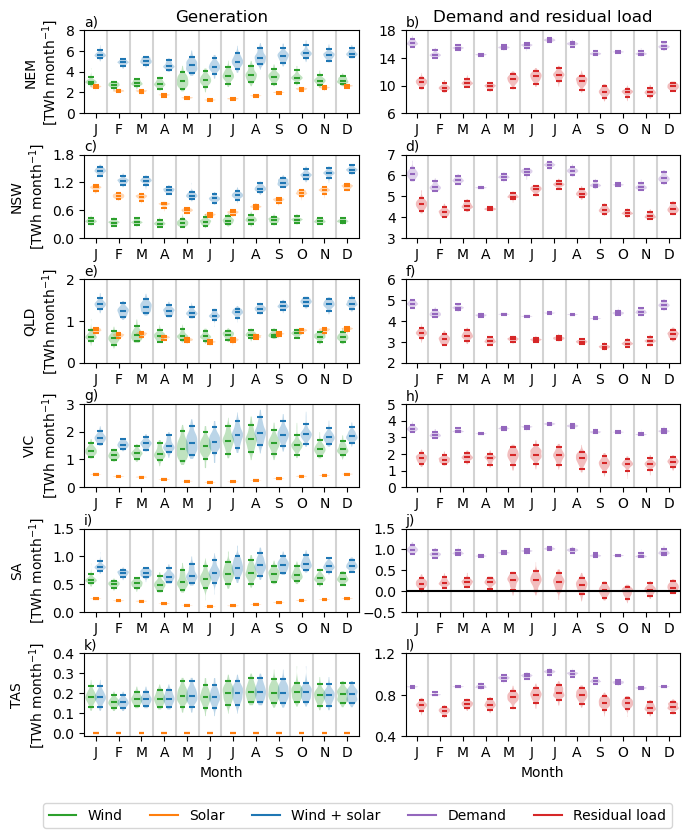

In [37]:
panel_violin(
    wind_current,
    solar_current,
    demand_current,
    shortfall_current,
    aemo_demand,
    ["NEM"]+REGIONS,
    plot_demand=True,
    colors=["tab:green", "tab:orange", "tab:blue"],
    yaxis_ticks=yaxis_ticks_current,
    savefig=True,
    filename="climatology_current"
)

### Compare current with future

In [36]:
def plot_boxplot(ax, ds_list, labels, colors=["tab:gray", "tab:orange", "tab:green"], x_offsets = [-0.2, 0, 0.2], v_width=0.5):
    """
    Plot data as vertical line limited at 5th and 95th percentiles.
    
    ax: axis to plot onto
    data_list: list, containing datasets to plot
    labels: list, labels of data
    colors: list, colors to plot. For 2 data sets, will exclude the middle one.
    x_offsets: list, spacing between data sets on x-axis. For 2 data sets, will exclude the middle one.
    v_width: float, widths of violins
    """
    legend_items = []
    def _add_label(violin, label):
        color = violin["bodies"][0].get_facecolor().flatten()
        legend_items.append((mpatches.Patch(color=color), label))
        
    # If only 2 datasets to plot, remove the middle color and x_offset
    if len(ds_list) == 2:
        colors = [colors[0], colors[-1]]
        x_offsets = [x_offsets[0], x_offsets[-1]]
    # If 4 datasets to plot, append new colour and change x_offsets
    if len(ds_list) == 4:
        colors = colors + ["tab:blue"]
        # x_offsets = [-0.2, -0.1, 0.1, 0.2]
        x_offsets = [-0.3, -0.1, 0.1, 0.3]
        
    # Get data for plotting
    data_list = [get_violin_data(d) for d in ds_list]
    
    # Plot
    for data, label, color, offset in zip(
        data_list, labels, colors, x_offsets
    ):
        q5 = [np.percentile(i, 5) for i in data]
        q50 = [np.percentile(i, 50) for i in data]
        q95 = [np.percentile(i, 95) for i in data]
        
        for q_data, s in zip([q5, q50, q95], [15, 10, 15]):
            ax.scatter(
                np.arange(1 + offset, 12.01 + offset, 1),
                q_data,
                marker="_",
                s=s,
                color=color
            )
        for x, y1, y2 in zip(
            np.arange(1 + offset, 12.01 + offset, 1),
            q5,
            q95
        ):
            ax.plot((x, x), (y1, y2), color=color) 
        
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(["J", "F", "M", "A", "M", "J", "J", "A", "S", "O", "N", "D"])
    ax.set_xlim(0.5, 12.5)
    for x in np.arange(1.5, 12, 1):
        ax.axvline(x, c="lightgray")
        
    return colors

In [38]:
def plot_compare_scenarios(ds_list, var_names_list, ylabel, plot_zero=True, colors=["tab:gray", "tab:orange", "tab:green"], suptitle=None, yaxis_ticks=None, savefig=False, filename=None):
    """
    Plot ds_list for each region
    """
    fig, ax = plt.subplots(3, 2, figsize=(7,5))
    
    for i, r in enumerate(ds_list[0].region.values[:]):
        color_list = plot_boxplot(
            ax.flatten()[i],
            [ds_list[j].sel(region=r) for j in range(len(ds_list))],
            var_names_list,
            v_width=0.3,
            colors=colors
        )
        if plot_zero:
            ax.flatten()[i].axhline(0, c="k")
        if i in [0, 2, 4]:
            ax.flatten()[i].set_ylabel(ylabel)
        ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)

    # Manual legend   
    cols = [Line2D([0], [0], marker='', linestyle="-", color=col) for col in color_list]

    plt.tight_layout()

    ax[2,0].legend(
        cols,
        var_names_list,
        loc=(0.3, -0.6),
        ncol=4,
        frameon=True
    )
    
    if suptitle is not None:
        plt.suptitle(suptitle, y=1.05)
        
    if isinstance(yaxis_ticks, list):
        for i, a in enumerate(ax.flatten()):
            a.set_yticks(yaxis_ticks[i])
        
    if savefig:
        plt.savefig("figures/" + filename + ".pdf", format="pdf", bbox_inches="tight")

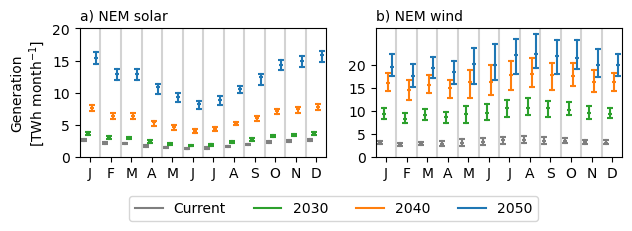

In [39]:
r = "NEM"

fig, ax = plt.subplots(1, 2, figsize=(7,5/3))
    
solar_ds_list = [
    solar_current,
    solar_SC30,
    solar_SC40,
    solar_SC50
]

wind_ds_list = [
    wind_current,
    wind_SC30,
    wind_SC40,
    wind_SC50
]

plot_boxplot(
    ax[0],
    [solar_ds_list[j].sel(region=r) for j in range(len(solar_ds_list))],
    ["Current", "2030", "2040", "2050"],
    v_width=0.3,
    colors=["tab:gray", "tab:green", "tab:orange"]
)

color_list = plot_boxplot(
    ax[1],
    [wind_ds_list[j].sel(region=r) for j in range(len(wind_ds_list))],
    ["Current", "2030", "2040", "2050"],
    v_width=0.3,
    colors=["tab:gray", "tab:green", "tab:orange"]
)
    
ax[0].set_title(letters[0] + ") NEM solar", loc="left", fontsize=10)
ax[1].set_title(letters[1] + ") NEM wind", loc="left", fontsize=10)

ax[0].set_ylabel("Generation\n" + r"[TWh month$^{-1}$]")

for i in range(2):
    ax[i].set_yticks(range(0, 21, 5))

# Manual legend   
cols = [Line2D([0], [0], marker='', linestyle="-", color=col) for col in color_list]

# plt.tight_layout()

ax[0].legend(
    cols,
    ["Current", "2030", "2040", "2050"],
    loc=(0.2, -0.5),
    ncol=4,
    frameon=True
)

# plt.savefig("figures/scenarios_NEM_wind_solar.pdf", format="pdf", bbox_inches="tight")

In [43]:
yaxis_ticks_scenario_resid = [
    range(-15, 16, 5),
    range(-4, 9, 4),
    range(-4, 5, 2),
    np.arange(-5, 5.1, 2.5),
    range(-3, 2, 1),
    np.arange(-0.4, 1.3, 0.4)
]

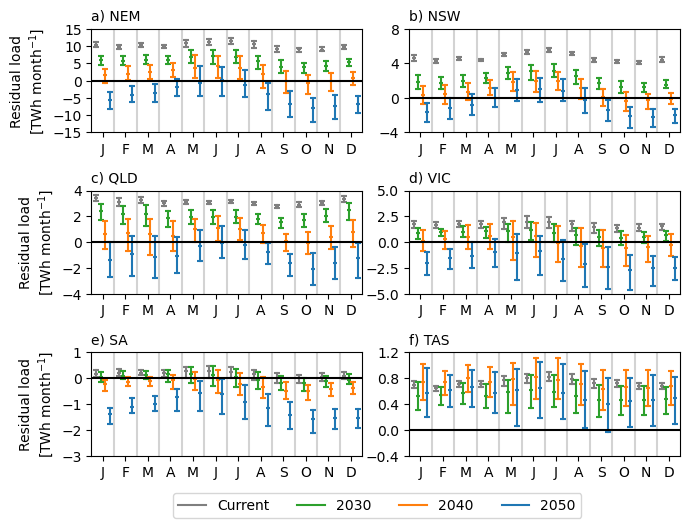

In [45]:
plot_compare_scenarios(
    [
        shortfall_current,
        shortfall_SC30,
        shortfall_SC40,
        shortfall_SC50
    ],
    [
        "Current",
        "2030",
        "2040",
        "2050"
    ],
    "Residual load\n" + r"[TWh month$^{-1}$]",
    colors=["tab:gray", "tab:green", "tab:orange"],
    # suptitle="Residual load for step change scenarios",
    yaxis_ticks=yaxis_ticks_scenario_resid,
    savefig=True,
    filename="scenarios_residload"
)

## Trends

In [29]:
def plot_time_series(ax, da, deg_smooth, ylabel, title):
    """
    Plot time series of 3-month averages, with x-year smoother
    """
    colors = ["tab:orange", "tab:blue", "tab:cyan", "tab:green"]
    labels = ["DJF", "MAM", "JJA", "SON"]

    for i, m in enumerate([2, 5, 8, 11]):
        _da_roll = da.rolling(time=3).mean()
        _da_m = _da_roll.isel(time=da.time.dt.month == m)
        _da_smooth = _da_m.rolling(time=deg_smooth).mean().isel(time=range(0, len(_da_m.time)))

        _da_smooth.plot(ax=ax, color=colors[i], ls="-", alpha=0.7, label=labels[i])
        
        ax.set_title("")
        ax.set_xlabel("")
        
    ax.set_ylabel(ylabel)
    ax.set_title(title, loc="left", fontsize=10)
    # ax.legend(ncols=4)

In [30]:
def panel_time_series(shortfall_da, demand_da, wind_da, solar_da, region, deg_smoother, suptitle=None, savefig=False, filename=None):
    """
    Time series of shortfall, demand, wind and solar for a given region.
    """
    fig, ax = plt.subplots(2, 2, figsize=(7,3))

    plot_time_series(
        ax[0,0],
        shortfall_da.sel(region=region),
        deg_smoother,
        "Residual load\n" + r"[TWh month$^{-1}$]",
        "Residual load (current)"
    )

    plot_time_series(
        ax[0,1],
        demand_da.sel(region=region),
        deg_smoother,
        "Load\n" + r"[TWh month$^{-1}$]",
        "Load (current)"
    )

    plot_time_series(
        ax[1,0],
        wind_da.sel(region=region),
        deg_smoother,
        "Wind power\n" + r"[TWh month$^{-1}$]",
        "Wind power (current)"
    )

    plot_time_series(
        ax[1,1],
        solar_da.sel(region=region),
        deg_smoother,
        "Solar power\n" + r"[TWh month$^{-1}$]",
        "Solar power (current)"
    )

    ax[0,0].set_xticklabels([])
    ax[0,1].set_xticklabels([])
    ax[1,0].tick_params(axis='x', labelrotation=30)
    ax[1,1].tick_params(axis='x', labelrotation=30)

    plt.tight_layout()

    # Manual legend   
    col1 = Line2D([0], [0], marker='', linestyle="-", color="tab:orange")
    col2 = Line2D([0], [0], marker='', linestyle="-", color="tab:blue")
    col3 = Line2D([0], [0], marker='', linestyle="-", color="tab:cyan")
    col4 = Line2D([0], [0], marker='', linestyle="-", color="tab:green")

    ax[1,0].legend(
        [col1, col2, col3, col4],
        ["DJF", "MAM", "JJA", "SON"],
        loc=(0.3, -0.8),
        ncol=4,
        frameon=True
    )
    
    if suptitle is not None:
        plt.suptitle(suptitle, y=1.05)
        
    if savefig:
        plt.savefig("figures/" + filename + ".pdf", format="pdf", bbox_inches="tight")

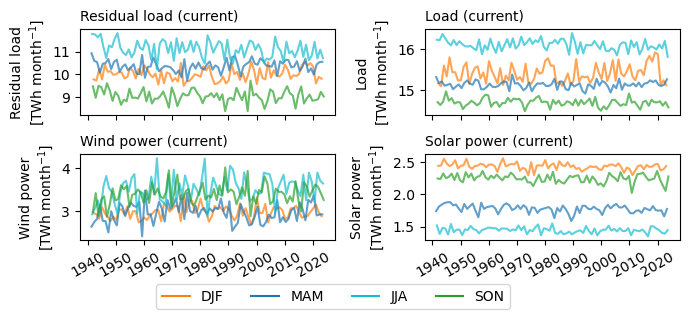

In [31]:
panel_time_series(shortfall_current, demand_current, wind_current, solar_current, "NEM", 1, savefig=True, filename="trends_NEM_current")

## Contribution of wind, solar to total demand

In [26]:
def annual_means(ds_list):
    """
    Annual means of ds_list for region
    """
    # return [ds.mean("time") for ds in ds_list]
    return [ds.resample(time="1YS").sum().mean("time") for ds in ds_list]

In [27]:
ann_dem = annual_means([demand_current, demand_SC30, demand_SC40, demand_SC50])
ann_wind = annual_means([wind_current, wind_SC30, wind_SC40, wind_SC50])
ann_solar = annual_means([solar_current, solar_SC30, solar_SC40, solar_SC50])

In [28]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# width = 0.2
# alpha = .8

# x = np.arange(4)
# xticklabels = ["Current", "2030", "2040", "2050"]

# pc_text_y_offsets = [i*13 for i in [1, 0.5, 0.5, 0.2, 0.1, 0.1]]

# for i, r in enumerate(demand_current.region.values):
    
#     p_dem = [ds.sel(region=r).values for ds in ann_dem]
#     p_wind = [ds.sel(region=r).values for ds in ann_wind]
#     p_solar = [ds.sel(region=r).values for ds in ann_solar]
    
#     # Wind and solar as a percentage of demand
#     pc_wind = np.array(p_wind) / p_dem * 100
#     pc_solar = np.array(p_solar) / p_dem * 100

#     ax.flatten()[i].bar(x-0.2, p_dem, width=width, color="tab:purple", alpha=alpha, label="Demand")
#     ax.flatten()[i].bar(x, p_wind, width=width, color="tab:green", alpha=1, label="Wind")
#     ax.flatten()[i].bar(x+0.2, p_solar, width=width, color="tab:orange", alpha=1, label="Solar")

#     for j in range(4):
#         # ax.flatten()[i].text(x[j]-0.2, p_dem[j]+0, "%i%" %np.round(p_dem[j]), rotation=90, fontsize=8, ha="center", va="bottom")
#         ax.flatten()[i].text(x[j]+0.07, p_wind[j]+pc_text_y_offsets[i], "%i%%" %np.round(pc_wind[j]), rotation=90, fontsize=7, ha="center", va="bottom")
#         if r != "TAS":
#             ax.flatten()[i].text(x[j]+0.33, p_solar[j]+pc_text_y_offsets[i], "%i%%" %np.round(pc_solar[j]), rotation=90, fontsize=7, ha="center", va="bottom")
    
#     ax.flatten()[i].set_xticks(x)
#     if i > 2:
#         ax.flatten()[i].set_xticklabels(xticklabels, rotation=30)
#     else:
#         ax.flatten()[i].set_xticklabels([])
    
#     ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)
    
#     print(r)
#     print(p_dem)
#     print(p_wind)
#     print(p_solar)
#     print()
    
# ax[0,0].set_yticks(range(0, 361, 60))
# ax[0,1].set_yticks(range(0, 151, 50))
# # ax[0,1].set_ylim(0, 120)
# ax[0,2].set_yticks(range(0, 151, 50))
# # ax[0,2].set_ylim(0, 120)
# ax[1,0].set_yticks(range(0, 121, 20))
# ax[1,1].set_yticks(range(0, 33, 8))
# ax[1,2].set_yticks(range(0, 33, 8))
    
# plt.subplots_adjust(wspace=0.3, hspace=0.3)
# ax[1,0].text(-1.9, 140, "Average energy " + r"[TWh year$^{-1}$]", rotation=90, ha="center", va="center")
# ax[-1,0].legend(frameon=True, ncols=3, loc=(0.8,-0.8))

# plt.savefig("figures/annual_consumption_scenario.pdf", format="pdf", bbox_inches="tight")

Stacked

NEM
[array(184.), array(216.), array(291.), array(340.)]
[array(38.578552, dtype=float32), array(115.109184, dtype=float32), array(196.68738, dtype=float32), array(242.78873, dtype=float32)]
[array(23.733076, dtype=float32), array(33.161118, dtype=float32), array(72.128716, dtype=float32), array(146.12283, dtype=float32)]

NSW
[array(70.), array(77.), array(90.), array(101.)]
[array(4.3249717, dtype=float32), array(34.402008, dtype=float32), array(51.030075, dtype=float32), array(61.747936, dtype=float32)]
[array(9.838358, dtype=float32), array(17.773495, dtype=float32), array(30.468067, dtype=float32), array(48.668644, dtype=float32)]

QLD
[array(53.), array(64.), array(90.), array(117.)]
[array(7.7481856, dtype=float32), array(31.346272, dtype=float32), array(52.335636, dtype=float32), array(64.96167, dtype=float32)]
[array(7.946224, dtype=float32), array(8.601252, dtype=float32), array(30.359234, dtype=float32), array(64.10342, dtype=float32)]

VIC
[array(41.), array(43.), array(75.

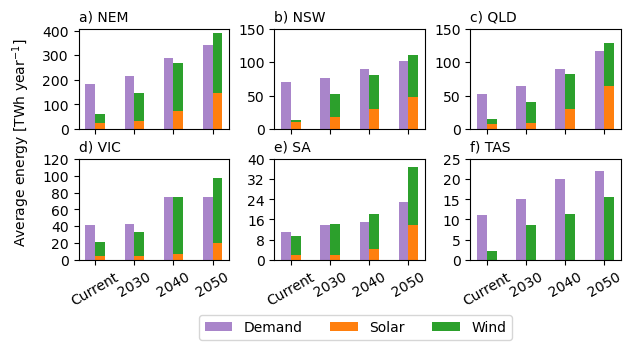

In [29]:
fig, ax = plt.subplots(2, 3, figsize=(7,3))

width = 0.25
alpha = .8

x = np.arange(4)
xticklabels = ["Current", "2030", "2040", "2050"]

pc_text_y_offsets = [i*13 for i in [1, 0.5, 0.5, 0.2, 0.1, 0.1]]

for i, r in enumerate(demand_current.region.values):
    
    p_dem = [ds.sel(region=r).values for ds in ann_dem]
    p_wind = [ds.sel(region=r).values for ds in ann_wind]
    p_solar = [ds.sel(region=r).values for ds in ann_solar]
    
    # Wind and solar as a percentage of demand
    pc_wind = np.array(p_wind) / p_dem * 100
    pc_solar = np.array(p_solar) / p_dem * 100

    ax.flatten()[i].bar(x-0.125, p_dem, width=width, color="tab:purple", alpha=alpha, label="Demand")
    # ax.flatten()[i].bar(x, p_wind, width=width, color="tab:green", alpha=1, label="Wind")
    ax.flatten()[i].bar(x+0.125, p_solar, width=width, color="tab:orange", alpha=1, label="Solar")
    ax.flatten()[i].bar(x+0.125, p_wind, bottom=p_solar, width=width, color="tab:green", alpha=1, label="Wind")

    # for j in range(4):
    #     # ax.flatten()[i].text(x[j]-0.2, p_dem[j]+0, "%i%" %np.round(p_dem[j]), rotation=90, fontsize=8, ha="center", va="bottom")
    #     ax.flatten()[i].text(x[j]+0.33, p_solar[j] + p_wind[j]/1, "%i%%" %np.round(pc_wind[j]), rotation=90, fontsize=7, ha="center", va="bottom")
    #     if r != "TAS":
    #         ax.flatten()[i].text(x[j]+0.33, p_solar[j]/2, "%i%%" %np.round(pc_solar[j]), rotation=90, fontsize=7, ha="center", va="bottom")
    
    ax.flatten()[i].set_xticks(x)
    if i > 2:
        ax.flatten()[i].set_xticklabels(xticklabels, rotation=30)
    else:
        ax.flatten()[i].set_xticklabels([])
    
    ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)
    
    print(r)
    print(p_dem)
    print(p_wind)
    print(p_solar)
    print()
    
ax[0,0].set_yticks(range(0, 401, 100))
ax[0,1].set_yticks(range(0, 151, 50))
# ax[0,1].set_ylim(0, 120)
ax[0,2].set_yticks(range(0, 151, 50))
# ax[0,2].set_ylim(0, 120)
ax[1,0].set_yticks(range(0, 121, 20))
ax[1,1].set_yticks(range(0, 41, 8))
ax[1,2].set_yticks(range(0, 26, 5))
    
plt.subplots_adjust(wspace=0.3, hspace=0.3)
ax[1,0].text(-1.9, 140, "Average energy " + r"[TWh year$^{-1}$]", rotation=90, ha="center", va="center")
ax[-1,0].legend(frameon=True, ncols=3, loc=(0.8,-0.8))

plt.savefig("figures/annual_consumption_scenario.pdf", format="pdf", bbox_inches="tight")

In [40]:
# fig, ax = plt.subplots(2, 3, figsize=(7,3))

# width = 0.2
# alpha = .8

# x = np.arange(4)
# xticklabels = ["Current", "2030", "2040", "2050"]

# for i, r in enumerate(demand_current.region.values):
    
#     p_dem = np.array([ds.sel(region=r).values for ds in ann_dem])
#     p_wind = np.array([ds.sel(region=r).values for ds in ann_wind]) / p_dem
#     p_solar = np.array([ds.sel(region=r).values for ds in ann_solar]) / p_dem

#     # ax.flatten()[i].bar(x-0.2, p_dem, width=width, color="tab:red", alpha=alpha, label="Demand")
#     ax.flatten()[i].bar(x-0.1, p_wind, width=width, color="tab:green", alpha=1, label="Wind")
#     ax.flatten()[i].bar(x+0.1, p_solar, width=width, color="tab:orange", alpha=1, label="Solar")

#     ax.flatten()[i].set_xticks(x)
#     if i > 2:
#         ax.flatten()[i].set_xticklabels(xticklabels, rotation=30)
#     else:
#         ax.flatten()[i].set_xticklabels([])
    
#     ax.flatten()[i].set_title(letters[i] + ") " + r, loc="left", fontsize=10)
    
#     ax.flatten()[i].set_yticks(np.arange(0, 1.01, 0.2))
#     if i not in [0, 3]:
#         ax.flatten()[i].set_yticklabels([])
    
#     # Right hand axis
#     # p_dem_change = p_dem / ann_dem[0].sel(region=r).values
#     # ax2 = ax.flatten()[i].twinx()
#     # ax2.bar(x+0.2, p_dem_change, width=width, color="tab:red", alpha=alpha, label="Demand")
    
#     print(r)
#     print(p_wind)
#     print(p_solar)
#     print(p_wind + p_solar)
#     print()
    
# plt.subplots_adjust(wspace=0.1, hspace=0.3)
# ax[1,0].text(-1.4, 1.1, "Proportion of load [-]", rotation=90, ha="center", va="center")

# ax[-1,0].legend(frameon=True, ncols=2, loc=(1,-0.8))

# plt.savefig("figures/annual_consumption_proportion_scenario.pdf", format="pdf", bbox_inches="tight")